In [27]:
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sb
from preprocessing import *
from model.convolutional_neural_network import *
from sklearn.model_selection import KFold
from model.Executor import *
import warnings  
warnings.filterwarnings("ignore")

import torch.nn.functional as functional


# Training Data

The statistics on the size of our dataset.

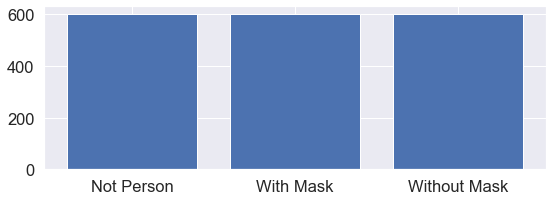

In [28]:
names = ['Not Person', 'With Mask', 'Without Mask']
N = []
N.append(len(os.listdir("./dataset/NotPerson")))
N.append(len(os.listdir("./dataset/WithMask")))
N.append(len(os.listdir("./dataset/WithoutMask")))
plt.figure(figsize=(9, 3))
plt.bar(names, N)
plt.show()

Create datasets for training and testing the model.

In [29]:
dataset = load_data("./dataset")
tr_ds, te_ds = split_data(dataset)
tr_loader = train_dataloarder(tr_ds)
te_loader = test_dataloarder(te_ds)

# Deep Learning

Implementing and training the CNN model.

In [30]:
num_epochs = 20
exec_obj = Executor()
all_loss,iter_loss,accuracy = exec_obj.training_model_executor(
    tr_loader,
    num_epochs
)


  0/20... rate=0 Hz, eta=?, total=0:00:00, wall=10:29 EST
current iter acc: 78.2222
current iter loss: 82.8507
  1/20... rate=0.05 Hz, eta=0:05:54, total=0:00:18, wall=10:29 EST
current iter acc: 87.3333
current iter loss: 69.1448
  2/20... rate=0.06 Hz, eta=0:05:25, total=0:00:36, wall=10:29 EST
current iter acc: 89.8519
current iter loss: 62.3878
  3/20... rate=0.06 Hz, eta=0:05:00, total=0:00:53, wall=10:30 EST
current iter acc: 91.9259
current iter loss: 56.8572
  4/20... rate=0.06 Hz, eta=0:04:41, total=0:01:10, wall=10:30 EST
current iter acc: 94.0000
current iter loss: 52.3691
  5/20... rate=0.06 Hz, eta=0:04:24, total=0:01:28, wall=10:30 EST
current iter acc: 95.4074
current iter loss: 47.6083
  6/20... rate=0.06 Hz, eta=0:04:07, total=0:01:45, wall=10:30 EST
current iter acc: 94.5185
current iter loss: 44.0028
  7/20... rate=0.06 Hz, eta=0:03:50, total=0:02:04, wall=10:31 EST
current iter acc: 94.1481
current iter loss: 41.7061
  8/20... rate=0.06 Hz, eta=0:03:33, total=0:02:2

In [31]:
testdata_accuracy = exec_obj.calculate_model_accuracy(te_loader)
print("Model accuracy for test dataset :",testdata_accuracy)
print(len(te_ds))

Model accuracy for test dataset : 95.55555555555556
450


# Saving the trained model.

In [32]:
save_path = os.path.join(os.path.abspath("."), "trained_model.pt")
torch.save(exec_obj.network.state_dict(), save_path)

In [41]:
exec_obj = Executor()

model = convolutional_neural_network.convolutional_neural_network()

model.load_state_dict(torch.load(save_path))

exec_obj.network = model

In [34]:
dataset_female = load_data("./biasTestData/Female")
dataset_male = load_data("./biasTestData/Male")
dataset_all = load_data("./biasTestData/All")

te_loader_female = test_dataloarder(dataset_female)
te_loader_male = test_dataloarder(dataset_male)
te_loader_all = test_dataloarder(dataset_all)

print("Model accuracy for test dataset(Female):", exec_obj.calculate_model_accuracy(te_loader_female))
print("Model accuracy for test dataset(Male):", exec_obj.calculate_model_accuracy(te_loader_male))
print("Model accuracy for test dataset(All):", exec_obj.calculate_model_accuracy(te_loader_all))



Model accuracy for test dataset(Female): 96.66666666666667
Model accuracy for test dataset(Male): 97.91666666666666
Model accuracy for test dataset(All): 97.05882352941177


# Evaluation the model - Female 

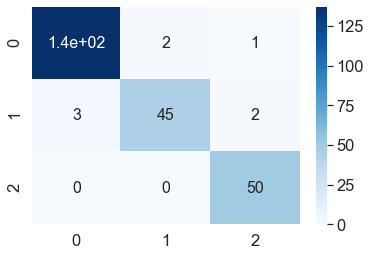

In [35]:
calc_model_weights, actual_results = next(iter(te_loader_female))
model_net = exec_obj.network(calc_model_weights)
pred_vals = torch.argmax(model_net, dim = 1)

sb.set(font_scale=1.5) 
sb.heatmap(
    confusion_matrix(actual_results.numpy(),pred_vals.numpy()),
    annot=True,
    annot_kws={"size": 16},
    cmap="Blues"
)  
plt.show()

In [36]:
report = classification_report(
    actual_results.numpy(),
    pred_vals.numpy(), 
    target_names=['with mask','without mask','not a person']
)
print(report)  

              precision    recall  f1-score   support

   with mask       0.98      0.98      0.98       140
without mask       0.96      0.90      0.93        50
not a person       0.94      1.00      0.97        50

    accuracy                           0.97       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.97      0.97      0.97       240



# Evaluation the model - Male 

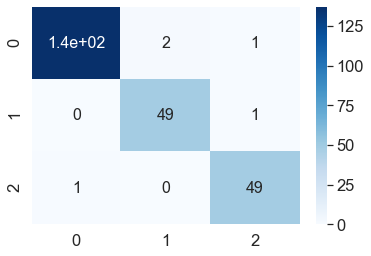

In [37]:
calc_model_weights, actual_results = next(iter(te_loader_male))
model_net = exec_obj.network(calc_model_weights)
pred_vals = torch.argmax(model_net, dim = 1)

sb.set(font_scale=1.5) 
sb.heatmap(
    confusion_matrix(actual_results.numpy(),pred_vals.numpy()),
    annot=True,
    annot_kws={"size": 16},
    cmap="Blues"
)  
plt.show()

# Evaluation: K-fold cross-validation

In [39]:
def doKfold(executor_obj, dataset, num_of_folds=10, num_of_epochs=10):
    all_epoch_loss = []
    result_loss_vals = []
    result_acy_vals = []
    
    cnt = 0
    kfold_obj = KFold(num_of_folds, shuffle=True)
    kf_dataset = kfold_obj.split(dataset)

    for idx, (trn_idx_vals, tst_idx_vals) in enumerate(kf_dataset):
        print("\nStart---KFOLD iteration {}\n".format(idx))
        print("Index lengths -- train idxs:{} test idxs:{}".format(len(trn_idx_vals), len(tst_idx_vals)))
        
        trn_data_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.Subset(dataset, trn_idx_vals), 
            shuffle=True,
            batch_size=50, 
            num_workers=2
        )
        
        tst_data_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.Subset(dataset, tst_idx_vals), 
            shuffle=True,
            batch_size=50, 
            num_workers=2
        )
        
        all_loss, epoch_loss, accuracy_vals = exec_obj.training_model_executor(trn_data_loader,  num_of_epochs)
        avg_loss = np.mean(all_loss)
        avg_accuracy = np.mean(accuracy_vals)
        
        result_loss_vals.append(avg_loss)
        all_epoch_loss.append(epoch_loss)
        result_acy_vals.append(avg_accuracy)
        
        
    return all_epoch_loss, result_loss_vals, result_acy_vals
        
        

exec_obj = Executor()        
        
all_epoch_loss, result_loss_vals, result_acy_vals = doKfold(exec_obj, tr_ds, num_of_folds=10, num_of_epochs=10)


Start---KFOLD iteration 0

Index lengths -- train idxs:1215 test idxs:135
  0/10... rate=0 Hz, eta=?, total=0:00:00, wall=10:38 EST
current iter acc: 32.3457
current iter loss: 97.1118
  1/10... rate=0.09 Hz, eta=0:01:36, total=0:00:10, wall=10:38 EST
current iter acc: 72.2634
current iter loss: 73.2122
  2/10... rate=0.09 Hz, eta=0:01:27, total=0:00:21, wall=10:38 EST
current iter acc: 91.7695
current iter loss: 58.7984
  3/10... rate=0.09 Hz, eta=0:01:15, total=0:00:32, wall=10:38 EST
current iter acc: 95.1440
current iter loss: 49.5418
  4/10... rate=0.10 Hz, eta=0:01:02, total=0:00:41, wall=10:38 EST
current iter acc: 97.2016
current iter loss: 42.4061
  5/10... rate=0.10 Hz, eta=0:00:50, total=0:00:50, wall=10:38 EST
current iter acc: 98.6831
current iter loss: 36.9359
  6/10... rate=0.10 Hz, eta=0:00:39, total=0:00:59, wall=10:39 EST
current iter acc: 98.1070
current iter loss: 32.9018
  7/10... rate=0.10 Hz, eta=0:00:29, total=0:01:09, wall=10:39 EST
current iter acc: 97.1193
c

current iter acc: 100.0000
current iter loss: 0.0039
  2/10... rate=0.11 Hz, eta=0:01:13, total=0:00:18, wall=10:47 EST
current iter acc: 100.0000
current iter loss: 0.0038
  3/10... rate=0.11 Hz, eta=0:01:04, total=0:00:27, wall=10:47 EST
current iter acc: 100.0000
current iter loss: 0.0037
  4/10... rate=0.11 Hz, eta=0:00:54, total=0:00:36, wall=10:47 EST
current iter acc: 100.0000
current iter loss: 0.0034
  5/10... rate=0.11 Hz, eta=0:00:45, total=0:00:45, wall=10:48 EST
current iter acc: 100.0000
current iter loss: 0.0034
  6/10... rate=0.11 Hz, eta=0:00:36, total=0:00:54, wall=10:48 EST
current iter acc: 100.0000
current iter loss: 0.0034
  7/10... rate=0.11 Hz, eta=0:00:27, total=0:01:03, wall=10:48 EST
current iter acc: 100.0000
current iter loss: 0.0034
  8/10... rate=0.11 Hz, eta=0:00:18, total=0:01:12, wall=10:48 EST
current iter acc: 100.0000
current iter loss: 0.0034
  9/10... rate=0.11 Hz, eta=0:00:09, total=0:01:22, wall=10:48 EST
current iter acc: 100.0000
current iter 

# Save the Kfold trained Model

In [40]:
kfold_save_path = os.path.join(os.path.abspath("."), "Kfold_trained_model.pt")
torch.save(exec_obj.network.state_dict(), kfold_save_path)

# Load the Kfold trained Model

In [41]:
exec_obj = Executor()

model = convolutional_neural_network.convolutional_neural_network()

model.load_state_dict(torch.load(kfold_save_path))

exec_obj.network = model

In [42]:
testdata_accuracy = exec_obj.calculate_model_accuracy(te_loader)
print("Model accuracy for test dataset :",testdata_accuracy)
print(len(te_ds))

Model accuracy for test dataset : 98.0
450


# Evaluating the Model

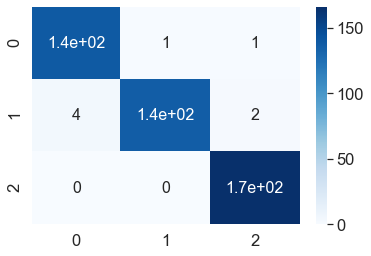

In [21]:
calc_model_weights, actual_results = next(iter(te_loader))
model_net = exec_obj.network(calc_model_weights)
pred_vals = torch.argmax(model_net, dim = 1)

sb.set(font_scale=1.5) 
sb.heatmap(
    confusion_matrix(actual_results.numpy(),pred_vals.numpy()),
    annot=True,
    annot_kws={"size": 16},
    cmap="Blues"
)  
plt.show()

# Classification report

In [22]:
report = classification_report(
    actual_results.numpy(),
    pred_vals.numpy(), 
    target_names=['with mask','without mask','not a person']
)
print(report)  

              precision    recall  f1-score   support

   with mask       0.97      0.99      0.98       141
without mask       0.99      0.96      0.98       143
not a person       0.98      1.00      0.99       166

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

